<a href="https://colab.research.google.com/github/Anam2291/Deep_Learning_Projects/blob/main/Lung_Cancer_Detection_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.applications import vgg16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:24<00:00, 58.4MB/s]
100% 1.76G/1.76G [00:24<00:00, 77.1MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
data_dir = '/content/LungCancer'  # base_dir
CATEGORIES = ['lung_adenocarcinomas', 'lung_normal', 'lung_squamous_cell_carcinomas']



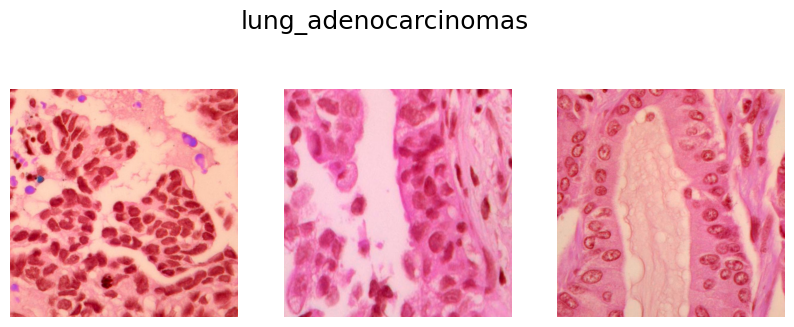

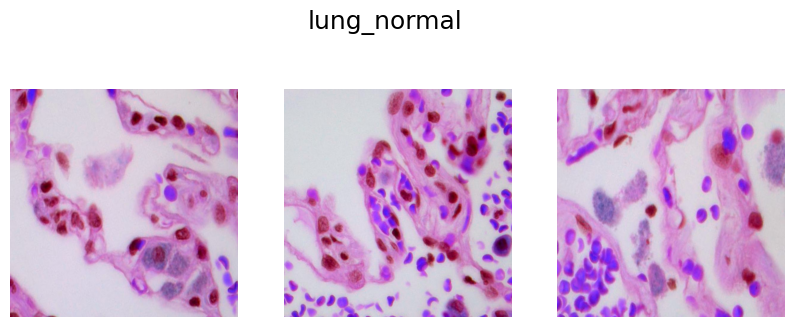

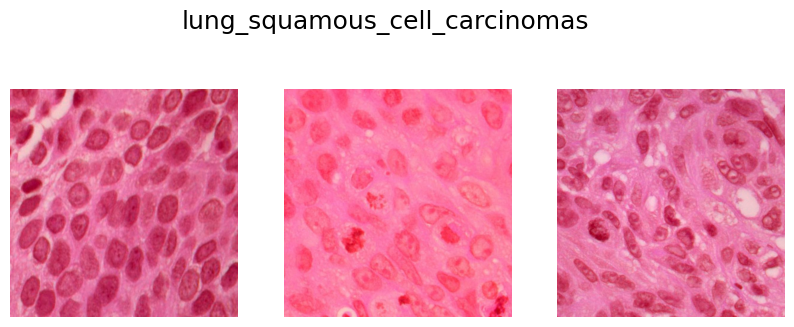

In [10]:
# Displaying the images
for category in CATEGORIES:
    path = os.path.join(data_dir, category)  # Constructing the path
    images = os.listdir(path)  # Extracting images from this particular path

    # Initialize a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 4)) # Subplot axes are managed using the ax array, making it more flexible and intuitive.
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        # Randomly select an image
        img_name = images[np.random.randint(0, len(images))] # Extracting any 3 random images from the entire range
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path) # To read the image data

        # Display the image
        ax[i].imshow(img_array) # Passing the data of images with the help of which display images
        ax[i].axis('off')





In [11]:
img_array.shape

(768, 768, 3)

**Converting Image into 224 Pixels**

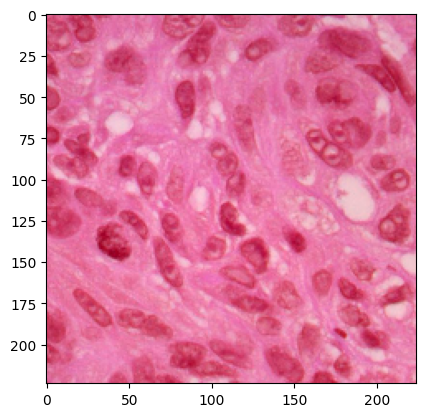

In [12]:
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)

In [13]:
new_array.shape

(224, 224, 3)

**Creating Training Data**

In [17]:
training_data = []    # Initializing training_data
def create_training_data():  #  Defining the Function
  for category in CATEGORIES:
    path = os.path.join(data_dir, category)  # data_dir: The root directory where the dataset is stored.
    labels = CATEGORIES.index(category) # class_num: The index of the current category in the CATEGORIES list, used as the label for that category.
    for img in os.listdir(path):   # Looping Through Images
      try:
        img_array = cv2.imread(os.path.join(path, img)) # Reads the image from the specified path as a NumPy array using OpenCV
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resizes the image to a uniform size (IMG_SIZE x IMG_SIZE).
                                              # This is crucial for feeding the data into a neural network, which requires consistent input dimensions.
        training_data.append([new_array, labels]) # Adds the resized image and its label as a pair to the training_data list.
      except Exception as e:  # Ensures that the loop continues even if an image cannot be read or resized due to errors (e.g., corrupted files).
        pass

create_training_data()


In [18]:
len(training_data)

15000

**Splits the preprocessed training_data** into two separate lists: one for the **features (X)** and the other for the **labels (y)**

**training_data: Contains pairs of images and labels, where each element is structured as [image_array, label].**

In [22]:
# Initializing Empty Lists
X = []          # X: Will store the image data (features).
y = []          # y: Will store the corresponding labels (targets/classes).

for features, labels in training_data:
  X.append(features)    # X.append(features): Adds the image data to the X list.
  y.append(labels)      # y.append(label): Adds the label to the y list.

In [23]:
type(X), type(y)

(list, list)


**Converting the data type of X and y from list to numpy array**

In [24]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)    # -1: Automatically infers the number of samples (i.e., the first dimension of the array).
                                                   # last value '3' for 'RGB'
y = np.array(y)   # Converts the Python list y (containing class labels) into a NumPy array.


In [25]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

#train-test split

In [26]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [27]:
print(f'X_train Length : {X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test Length : {X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')


X_train Length : 12000, X_train Image size : (224, 224), Channel Dimension : 3
X_test Length : 3000, X_test Image size : (224, 224), Channel Dimension : 3


# Initializes a pre-trained VGG16 model from Keras

**The VGG16 model acts as a feature extractor for input images.**

**The feature maps will be passed to custom layers (e.g., dense or fully connected layers) to train the model on your dataset.**

In [28]:
vgg = vgg16.VGG16(weights = 'imagenet', # weights='imagenet' Specifies that the model should load pre-trained weights from the ImageNet dataset.
                  include_top = False, # include_top=False Indicates that the fully connected (classification) layers
                                       # at the top of the VGG16 model should be excluded.
                  input_shape = (IMG_SIZE, IMG_SIZE, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Freezes the pre-trained VGG16 convolutional layers

   - The convolutional layers in VGG16 are pre-trained on the ImageNet dataset.
   - These layers have learned generic features such as edges, textures, and patterns, which are often applicable to a wide variety of images.
   - Freezing these layers preserves the pre-trained features and speeds up training.

- **Focus on Custom Layers:**

The model will only train the additional (custom) layers added on top, enabling it to adapt to your specific classification task (e.g., lung cancer classification).


In [29]:
# freezing the bottom (conv) layers
for layer in vgg.layers:
  layer.trainable = False


# Building the Top (Fully Connected) Layers

In [30]:
model = keras.Sequential([      # keras.Sequential is a linear stack of layers
    vgg, # Includes the pre-trained VGG16 model without the top classification layers (include_top=False).All convolutional and pooling layers act as a feature extractor.
    keras.layers.GlobalAveragePooling2D(),  # Global Average Pooling (reduces feature map size).
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'), # 3:Number of neurons corresponds to the number of classes
                                                    # (e.g., 3 categories: lung adenocarcinoma, lung normal, lung squamous cell carcinoma).

])